Loading and spliting the data


In [ ]:
from datasets import load_dataset, DatasetDict
import gc

print("Load dataset")
dataset = load_dataset("marcelomoreno26/geoguessr", split='train', streaming=True)

countries = ['Japan', 'France', 'Mexico']
samples_per_country = 400  #Mexico = 400

filtered_data = []
country_counts = {c: 0 for c in countries}

for item in dataset:
    country = item['label']
    if country in countries and country_counts[country] < samples_per_country:
        filtered_data.append({
            'image': item['image'],
            'label': countries.index(country)
        })
        country_counts[country] += 1

    if all(c >= samples_per_country for c in country_counts.values()):
        break

print(f"Final counts: {country_counts}")
print(f"Total: {len(filtered_data)} images")

del dataset
gc.collect()
print("Dataset loading complete, memory cleaned")

Load dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/589 [00:00<?, ?B/s]

Final counts: {'Japan': 400, 'France': 400, 'Mexico': 400}
Total: 1200 images
Dataset loading complete, memory cleaned


split to: train, validation and test

In [ ]:
from sklearn.model_selection import train_test_split

labels = [item['label'] for item in filtered_data]

train_val, test = train_test_split(filtered_data, test_size=0.15, stratify=labels, random_state=42)

train_val_labels = [item['label'] for item in train_val]
train, validation = train_test_split(train_val, test_size=0.176, stratify=train_val_labels, random_state=42)

print(f"Train: {len(train)}")
print(f"Validation: {len(validation)}")
print(f"Test: {len(test)}")

Train: 840
Validation: 180
Test: 180


Plotting and Visualizing

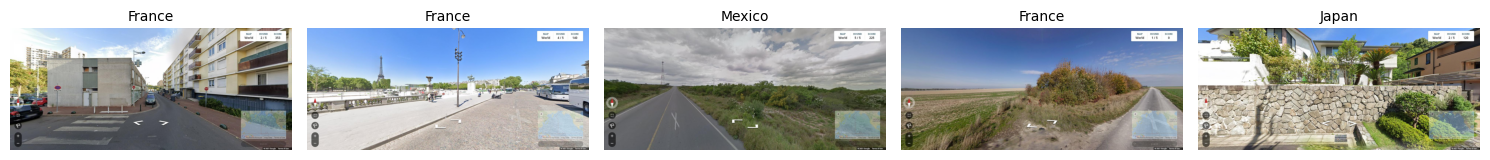

In [ ]:
import matplotlib.pyplot as plt

# Show 5 example images
num_examples = 5
examples = train[:num_examples]

plt.figure(figsize=(15, 10))
for i, example in enumerate(examples):
    plt.subplot(1, num_examples, i + 1)
    image = example['image']
    label_idx = example['label']
    country = countries[label_idx]

    plt.imshow(image)
    plt.title(country, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

prepare the model

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

checkpoint = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(countries),
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([3, 768])
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([3])          

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


prepare data for the model


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class GeoGuessrDataset(Dataset):
    def __init__(self, data, processor, augment=False):
        self.data = data
        self.processor = processor
        self.augment = augment

        self.aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']

        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image)).convert('RGB')

        if self.augment:
            image = self.aug_transform(image)

        encoding = self.processor(images=image, return_tensors='pt')
        pixel_values = encoding['pixel_values'].squeeze(0)

        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }


import torch
import numpy as np

train_dataset = GeoGuessrDataset(train, processor, augment=True)
val_dataset = GeoGuessrDataset(validation, processor, augment=False)
test_dataset = GeoGuessrDataset(test, processor, augment=False)

print("Datasets created")

# Memory cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

Datasets created
CUDA cache cleared


training

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
        output_dir="geoguessr-vit-finetuned",
        learning_rate=2e-5,
        num_train_epochs=15,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=2,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=10,
        remove_unused_columns=False,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        warmup_steps=100,
        lr_scheduler_type="cosine",
        weight_decay=0.01,
        save_total_limit=3,
        report_to="none",
    )


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("Start training")
trainer.train()


gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.190674,1.167484,0.272222,0.273031,0.272222,0.266992
2,0.995811,1.021254,0.455556,0.462805,0.455556,0.454886
3,0.778757,0.840509,0.644444,0.660173,0.644444,0.645299
4,0.573179,0.643515,0.750000,0.772012,0.750000,0.749481
5,0.402077,0.490446,0.827778,0.837846,0.827778,0.827589
6,0.197380,0.401067,0.872222,0.879479,0.872222,0.871758
7,0.144887,0.439710,0.816667,0.844815,0.816667,0.812952
8,0.102242,0.352430,0.883333,0.898148,0.883333,0.882167
9,0.047167,0.358878,0.872222,0.891470,0.872222,0.869519
10,0.028836,0.311344,0.883333,0.894444,0.883333,0.882941


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

CUDA cache cleared


Training history visualization

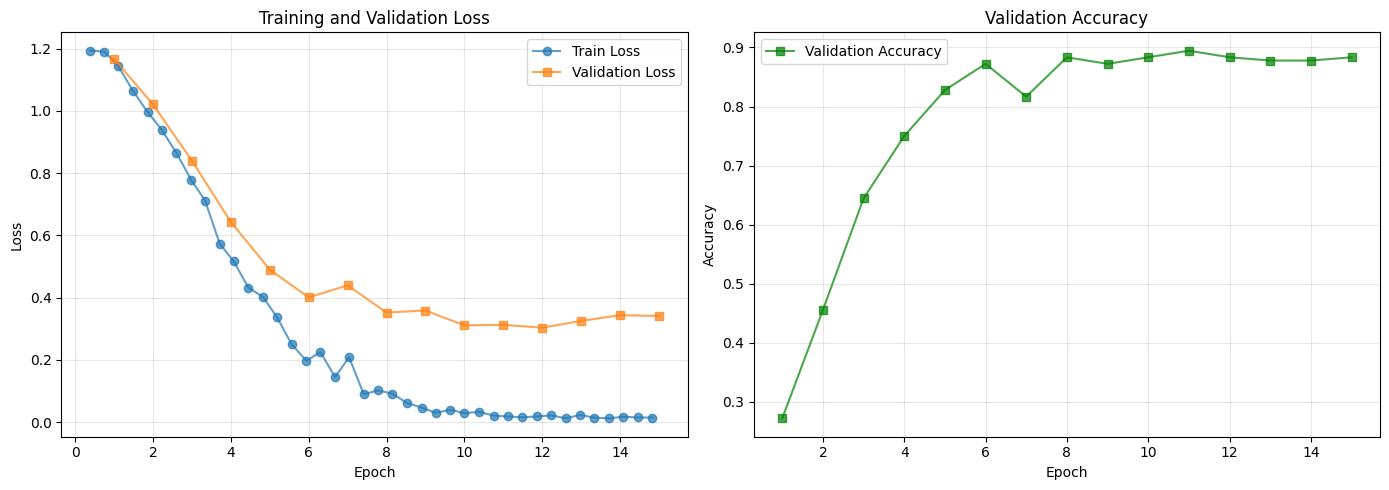

Training history visualized


In [ ]:
import matplotlib.pyplot as plt

# Extract training history from trainer logs
log_history = trainer.state.log_history

# Parse logs
train_loss = []
eval_loss = []
eval_accuracy = []
epochs = []

for entry in log_history:
    if 'loss' in entry and 'epoch' in entry:
        # Training loss
        if 'eval_loss' not in entry:
            train_loss.append((entry['epoch'], entry['loss']))
    if 'eval_loss' in entry:
        # Validation metrics
        eval_loss.append((entry['epoch'], entry['eval_loss']))
        if 'eval_accuracy' in entry:
            eval_accuracy.append((entry['epoch'], entry['eval_accuracy']))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
if train_loss:
    train_epochs, train_losses = zip(*train_loss)
    axes[0].plot(train_epochs, train_losses, 'o-', label='Train Loss', alpha=0.7)
if eval_loss:
    eval_epochs, eval_losses = zip(*eval_loss)
    axes[0].plot(eval_epochs, eval_losses, 's-', label='Validation Loss', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
if eval_accuracy:
    eval_epochs, eval_accs = zip(*eval_accuracy)
    axes[1].plot(eval_epochs, eval_accs, 's-', label='Validation Accuracy', color='green', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training history visualized")

evaluation

In [ ]:

test_results = trainer.evaluate(test_dataset)

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Accuracy: {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.1f}%)")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")


TEST RESULTS
Accuracy: 0.9000 (90.0%)
Precision: 0.9043
Recall: 0.9000
F1 Score: 0.9001


visualization

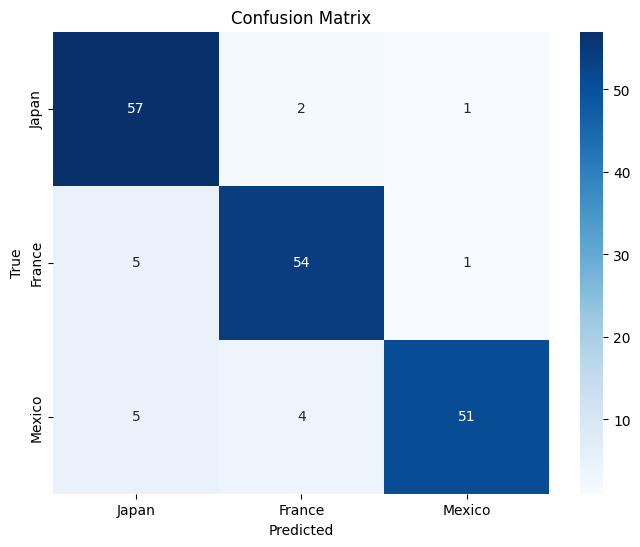

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=countries, yticklabels=countries)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

save model

In [ ]:
# Save the model
model.save_pretrained("geoguessr-model")
processor.save_pretrained("geoguessr-model")

# Save country mapping
import json
country_mapping = {i: country for i, country in enumerate(countries)}
with open('geoguessr-model/country_mapping.json', 'w') as f:
    json.dump(country_mapping, f)

print("Model saved")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved


test prediction


 Predicted: Mexico
 Confidence: 92.0%

All Probabilities:
  Mexico          ████████████████████████████████████░░░░  92.0%
  Japan           ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5.7%
  France          ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2.3%


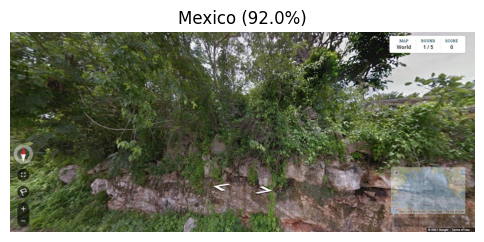

True label: Mexico


In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

def predict_image(image_path, model, processor, countries):
    device = next(model.parameters()).device
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_class = probs.argmax(dim=1).item()
        confidence = probs[0, pred_class].item()

    result = {
        'country': countries[pred_class],
        'confidence': confidence,
        'all_probs': {countries[i]: probs[0, i].item() for i in range(len(countries))}
    }

    print(f"\n Predicted: {result['country']}")
    print(f" Confidence: {result['confidence']*100:.1f}%")
    print("\nAll Probabilities:")
    for c, p in sorted(result['all_probs'].items(), key=lambda x: x[1], reverse=True):
        bar = '█' * int(p*40) + '░' * (40-int(p*40))
        print(f"  {c:15s} {bar} {p*100:5.1f}%")

    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{result['country']} ({result['confidence']*100:.1f}%)")
    plt.show()

    return result
test_image = test[0]['image']
import tempfile
with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as f:
    test_image.save(f.name)
    result = predict_image(f.name, model, processor, countries)
print(f"True label: {countries[test[0]['label']]}")

uploading image for test

Saving image (2).jpg to image (2).jpg

 Predicted: France
 Confidence: 85.0%

All Probabilities:
  France          ██████████████████████████████████░░░░░░  85.0%
  Mexico          ███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   7.5%
  Japan           ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   7.5%


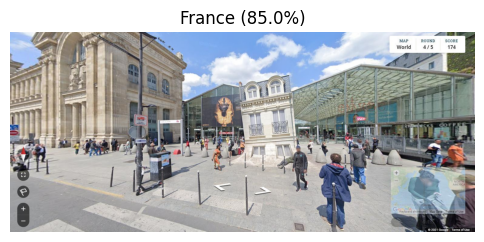

In [ ]:
try:
    from google.colab import files
    uploaded = files.upload()

    if uploaded:
        image_path = list(uploaded.keys())[0]
        result = predict_image(image_path, model, processor, countries)
except ImportError:
    print("Not in Colab. Use predict_image(path, model, processor, countries) to test.")

summary

In [ ]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Countries: {countries}")

total_samples = len(filtered_data)

print(f"Dataset: {total_samples} images (balanced)")
for country, count in country_counts.items():
    print(f"  {country}: {count}")
# print(f"\nModel: {'Full fine-tuning'}")
# print(f"Memory mode: {'In-memory'}")
print(f"\nTest Accuracy: {test_results['eval_accuracy']:.2%}")
print(f"Test F1 Score: {test_results['eval_f1']:.2%}")



SUMMARY
Countries: ['Japan', 'France', 'Mexico']
Dataset: 1200 images (balanced)
  Japan: 400
  France: 400
  Mexico: 400

Test Accuracy: 90.00%
Test F1 Score: 90.01%
